In [10]:
import cv2
import numpy as np

# Read the image
image = cv2.imread('12_Morning.jpg')

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range for green color in HSV (adjusted for bright green leaves)
lower_green = np.array([35, 70, 70])
upper_green = np.array([90, 255, 255])

# Create a mask for green color
mask = cv2.inRange(hsv, lower_green, upper_green)

# Apply the mask to the original image
result = cv2.bitwise_and(image, image, mask=mask)

cv2.imwrite('hsv_segmentation.jpg', result)
cv2.imwrite('green_mask.jpg', mask)


True

In [11]:
import cv2
import numpy as np

# Read the binary mask from previous step
binary = cv2.imread('green_mask.jpg', 0)

# Create kernels for morphological operations
small_kernel = np.ones((3,3), np.uint8)
large_kernel = np.ones((7,7), np.uint8)

# Remove small noise with opening
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, small_kernel, iterations=2)

# Fill holes with closing
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, large_kernel, iterations=3)

cv2.imwrite('morphological_cleaned.jpg', closing)


True

In [12]:
import cv2
import numpy as np

# Read the cleaned binary image
binary = cv2.imread('morphological_cleaned.jpg', 0)

# Find contours
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area to remove small noise
min_contour_area = 500  # Adjust based on your image scale
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

# Draw contours on original image
image = cv2.imread('12_Morning.jpg')
cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 2)

# Count leaves (filtered contours)
leaf_count = len(filtered_contours)

# Add text to image
cv2.putText(image, f'Leaf count: {leaf_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

cv2.imwrite('accurate_leaf_count.jpg', image)


True

In [13]:
import cv2
import numpy as np

# Read the cleaned binary image
binary = cv2.imread('morphological_cleaned.jpg', 0)

# Find contours
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area
min_contour_area = 500
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

# Create a blank image to draw the filtered contours
leaf_mask = np.zeros_like(binary)
cv2.drawContours(leaf_mask, filtered_contours, -1, 255, -1)

# Count white pixels (leaf area)
leaf_area_pixels = np.sum(leaf_mask == 255)

# Assuming 1 cm² = X pixels (you need to calibrate this)
# For example, if you know the pot diameter is 5 cm
pot_diameter_cm = 5
pot_diameter_pixels = binary.shape[1]  # Assuming pot width is image width
pixels_per_cm2 = (pot_diameter_pixels / pot_diameter_cm) ** 2

leaf_area_cm2 = leaf_area_pixels / pixels_per_cm2

# Create a color image to show the measured area
original = cv2.imread('12_Morning.jpg')
result = original.copy()
colored_mask = cv2.cvtColor(leaf_mask, cv2.COLOR_GRAY2BGR)
colored_mask[leaf_mask == 255] = [0, 255, 0]  # Green color for leaves

# Blend the original image with the colored mask
alpha = 0.5
result = cv2.addWeighted(result, 1, colored_mask, alpha, 0)

# Add text showing the leaf area
cv2.putText(result, f'Leaf area: {leaf_area_cm2:.2f} cm²', (10, 60), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

cv2.imwrite('leaf_area_measurement.jpg', result)


True

True

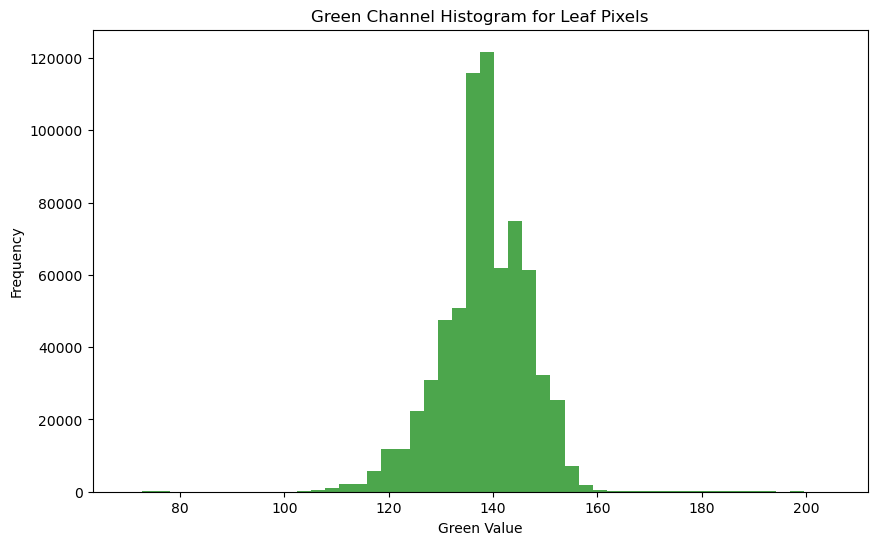

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the original image and the leaf mask
original = cv2.imread('12_Morning.jpg')
leaf_mask = cv2.imread('morphological_cleaned.jpg', 0)

# Convert BGR to RGB for better color analysis
rgb_image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Extract only the leaf pixels using the mask
leaf_pixels = rgb_image[leaf_mask == 255]

# Calculate average RGB values
avg_r = np.mean(leaf_pixels[:, 0])
avg_g = np.mean(leaf_pixels[:, 1])
avg_b = np.mean(leaf_pixels[:, 2])

# Create a histogram of green channel values
plt.figure(figsize=(10, 6))
plt.hist(leaf_pixels[:, 1], bins=50, color='green', alpha=0.7)
plt.title('Green Channel Histogram for Leaf Pixels')
plt.xlabel('Green Value')
plt.ylabel('Frequency')
plt.savefig('leaf_green_histogram.jpg')

# Create a color analysis image
result = original.copy()
cv2.putText(result, f'Avg RGB: ({avg_r:.1f}, {avg_g:.1f}, {avg_b:.1f})', 
            (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

cv2.imwrite('leaf_color_analysis.jpg', result)
